**이 NoteBook에서는 Deep한 Layer에서도 똑같이 적용이 되는것인지 확인해보겠다.**
* 충분히 성능이 괜찮은 모델에서도 성능향상이 있을까?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 모델 구성하기

In [2]:
data = pd.read_csv('./TrafficData/4-Copy1.csv')
data = data['volumn']
sequence_length = 1440
pred_len = 1

In [3]:
from torch import FloatTensor as FloatTensor

In [4]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(len(x)-sequence_length-pred_len):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [5]:
split = 10080

In [6]:
seed = 42

In [7]:
device = torch.device("cuda:0")

In [8]:
X_test = torch.FloatTensor(data.iloc[-split-sequence_length:-split].values).to(device)
# X_train의 마지막 인덱스에서 sequece_length만큼 뒤에 부분을 잘라오기
X_test = X_test.view(1,1,sequence_length)

In [9]:
target = data.iloc[-split]
target = FloatTensor([target]).view(-1,1)
target

tensor([[90520.]])

In [10]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 1
        self.train_index = train_index
        self.first_layer = nn.Linear(self.seq_len,self.seq_len//2)
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.seq_len//2,self.seq_len]))
        self.second_layer = nn.Linear(self.seq_len//2,self.seq_len//4)
        self.second_layer.weight = nn.Parameter((1/(self.seq_len//2))*torch.ones([self.seq_len//4,self.seq_len//2]))
        self.third_layer = nn.Linear(self.seq_len//4,self.pred_len)
        self.third_layer.weight = nn.Parameter((1/(self.seq_len//4))*torch.ones([self.pred_len,self.seq_len//4]))
    def forward(self,x):
        mid_result1 = self.first_layer(x[:,:,self.train_index])
        mid_result2 = self.second_layer(mid_result1)
        return  self.third_layer(mid_result2)

<font color = blue>**X_test는 실제로는 train_set중에 일부이다. 그렇다면 train-validation set으로 쪼개서 validation set으로 나눠서 성능측정을 해보자**</font>

# 2. Train-Validation set으로 쪼개기

In [11]:
data

0        104771
1        101830
2        100160
3        100484
4         97533
          ...  
38875     91244
38876     88830
38877     92001
38878     88159
38879     91109
Name: volumn, Length: 38880, dtype: int64

* 10080개는 test set 
* 28800개 중 0.2의 비율인 1440*4 = 5760개는 validation set
* 28800개 중 0.8의 비율인 28800-5760 = 23040개는 train set

In [12]:
train = data.iloc[:-split-5760]
val = data.iloc[-split-5760:-split]
x_train,y_train = seq_data(train,sequence_length=1440,pred_len=1)
x_val,y_val = seq_data(val,sequence_length=1440,pred_len=1)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_2445288/4291513198.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [13]:
next(iter(validation))[0].size()

torch.Size([64, 1, 1440])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [14]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(1440)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
criterion = SMAPE()
num_epochs = 100
n= len(training)

### 수렴하지 않는 문제 때문에 scheduler를 사용

In [15]:
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer = optimizer,
                                             lr_lambda = lambda epoch : 0.95** epoch)

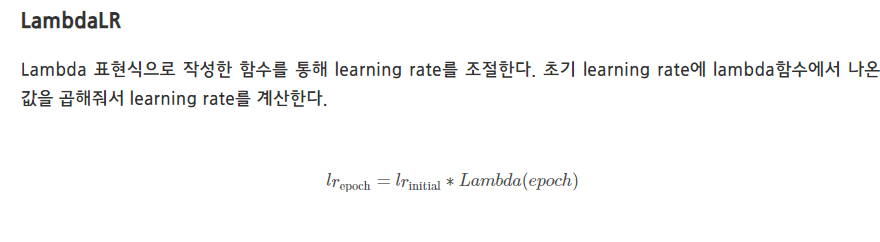
-> 초기 learning_rate에 계속 곱하는 것이다.<br>
-> 백과사전 참고

### 기본 모델 training

In [16]:
lr_list = []

In [17]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        # defining loss
        loss = criterion(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    lr_list.append(optimizer.param_groups[0]['lr']) # 이것을 기록해서 learning rate를 기록 할 수 있다.
    scheduler.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    running_loss = 0.0

Epoch [1]/[100] running accumulative loss across all batches: 48.513
Epoch [21]/[100] running accumulative loss across all batches: 16.099
Epoch [41]/[100] running accumulative loss across all batches: 10.405
Epoch [61]/[100] running accumulative loss across all batches: 8.490
Epoch [81]/[100] running accumulative loss across all batches: 8.168


<AxesSubplot: >

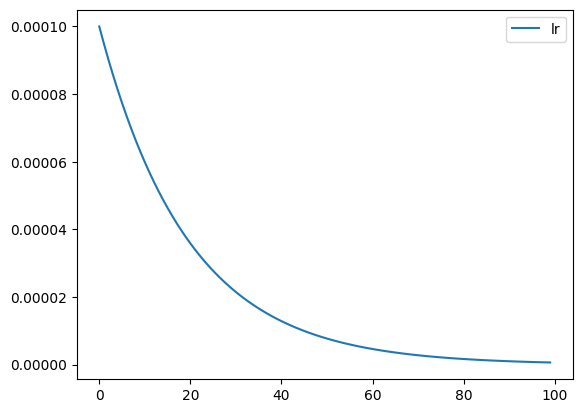

In [18]:
lr_df = pd.DataFrame({'lr':lr_list})
lr_df.plot()

### validation set에 대해서 attribution 구하기

In [19]:
n = len(validation)
n

68

In [20]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((1,1440))
for val in validation:
    temp_n = val[0].size(0)
    temp = nt_ig.attribute(val[0]).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음
    nt_ig_attr_score = nt_ig_attr_score.to(device)+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [21]:
len(nt_ig_attr_score)

1440

<AxesSubplot: >

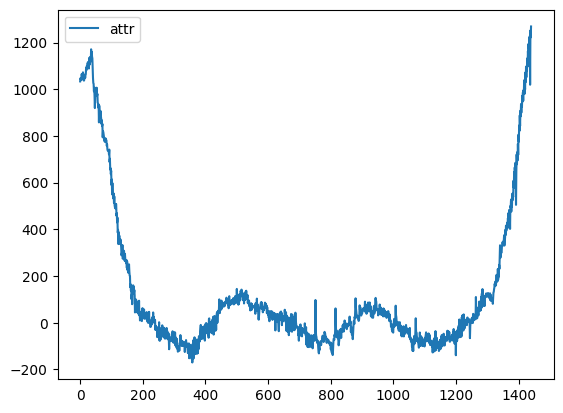

In [22]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

### outlier가 감쇄 됐음을 확인할 수 있다.

#### scaling

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
attr_df

,attr
0,2.885997
1,2.929935
2,2.914644
3,2.922613
4,2.903534
...,...
1435,3.505775
1436,2.840693
1437,3.581792
1438,3.487308


In [24]:
attr_df.describe()

,attr
count,1.440000e+03
mean,4.934325e-17
std,1.000347e+00
min,-9.528840e-01
25%,-5.707117e-01
50%,-3.456488e-01
75%,-9.102462e-02
max,3.636252e+00


#### train_index구하기
&rightarrow; describe상의 최솟값이 -0.95 max값이 3.63이기에 더 작은 값 까지만 살펴봄

In [25]:
index_list = []

for hyper_parameter in np.arange(0.01,0.96 ,0.01): 
    append_idx = list(attr_df[(attr_df['attr']>hyper_parameter) | (attr_df['attr']<-hyper_parameter)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

95

In [26]:
len_list=[]
for i in range(95):
    len_list.append(len(index_list[i]))

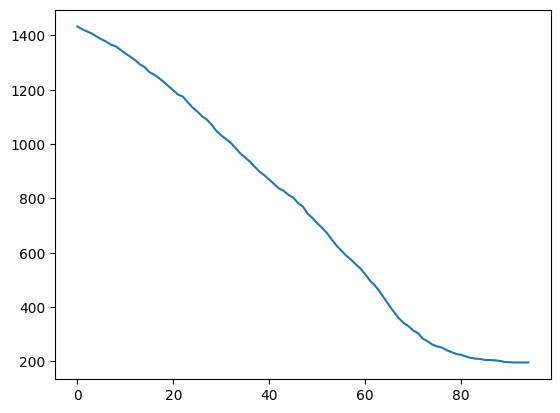

In [27]:
plt.plot(np.arange(95),len_list) # 포함되는 time_index의 갯수

In [28]:
for val_x,val_y in validation:
    print(val_x,val_y)

tensor([[[ 99460.,  90047.,  97806.,  ..., 109476., 107938., 110427.]],

        [[ 90047.,  97806.,  87141.,  ..., 107938., 110427., 112393.]],

        [[ 97806.,  87141.,  94147.,  ..., 110427., 112393., 107838.]],

        ...,

        [[ 74547.,  76519.,  69353.,  ...,  89959.,  83763., 150861.]],

        [[ 76519.,  69353.,  72669.,  ...,  83763., 150861.,  84639.]],

        [[ 69353.,  72669.,  67592.,  ..., 150861.,  84639.,  88357.]]],
       device='cuda:0') tensor([[[112393.]],

        [[107838.]],

        [[109474.]],

        [[106154.]],

        [[109562.]],

        [[104609.]],

        [[108481.]],

        [[104811.]],

        [[108068.]],

        [[101610.]],

        [[109562.]],

        [[102103.]],

        [[107085.]],

        [[101324.]],

        [[103611.]],

        [[ 97023.]],

        [[103033.]],

        [[ 97762.]],

        [[102938.]],

        [[ 95425.]],

        [[100112.]],

        [[ 92605.]],

        [[ 97253.]],

        [[ 92184.]

       device='cuda:0') tensor([[[53888.]],

        [[58570.]],

        [[54112.]],

        [[58511.]],

        [[52054.]],

        [[56811.]],

        [[53236.]],

        [[59650.]],

        [[57014.]],

        [[59480.]],

        [[57445.]],

        [[60725.]],

        [[60157.]],

        [[62308.]],

        [[59503.]],

        [[61852.]],

        [[58037.]],

        [[60803.]],

        [[57891.]],

        [[60890.]],

        [[57829.]],

        [[61248.]],

        [[58404.]],

        [[61365.]],

        [[58457.]],

        [[62000.]],

        [[57509.]],

        [[61571.]],

        [[57362.]],

        [[62044.]],

        [[57484.]],

        [[61551.]],

        [[58428.]],

        [[62239.]],

        [[57884.]],

        [[62690.]],

        [[56771.]],

        [[61206.]],

        [[58290.]],

        [[62799.]],

        [[57810.]],

        [[63584.]],

        [[59762.]],

        [[65012.]],

        [[58844.]],

        [[64045.]],

        [[

       device='cuda:0') tensor([[[267762.]],

        [[278717.]],

        [[269267.]],

        [[278622.]],

        [[267819.]],

        [[275509.]],

        [[270925.]],

        [[277365.]],

        [[270402.]],

        [[275113.]],

        [[271397.]],

        [[277032.]],

        [[271108.]],

        [[277653.]],

        [[268130.]],

        [[279989.]],

        [[272548.]],

        [[280160.]],

        [[270812.]],

        [[279906.]],

        [[291858.]],

        [[283029.]],

        [[290750.]],

        [[285491.]],

        [[288744.]],

        [[276838.]],

        [[289848.]],

        [[274065.]],

        [[291786.]],

        [[274834.]],

        [[291562.]],

        [[274759.]],

        [[291827.]],

        [[271395.]],

        [[291419.]],

        [[269927.]],

        [[290329.]],

        [[269032.]],

        [[288728.]],

        [[278930.]],

        [[291164.]],

        [[276166.]],

        [[287788.]],

        [[278617.]],

        

In [29]:
val_x

tensor([[[ 97152.,  93410.,  97749.,  ..., 103395.,  99170., 103273.]],

        [[ 93410.,  97749.,  92393.,  ...,  99170., 103273.,  97323.]],

        [[ 97749.,  92393.,  94468.,  ..., 103273.,  97323., 102155.]],

        ...,

        [[ 85870.,  82298.,  85843.,  ...,  91668.,  87325.,  91681.]],

        [[ 82298.,  85843.,  85797.,  ...,  87325.,  91681.,  88167.]],

        [[ 85843.,  85797.,  90281.,  ...,  91681.,  88167.,  89379.]]],
       device='cuda:0')

In [30]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
out_list = []
num_epochs = 100
criterion = SMAPE()
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer = optimizer,
                                             lr_lambda = lambda epoch : 0.95** epoch)
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        scheduler.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
    cnt+=1
    # 모델 Fully-Training 완료
    
    for val_x,val_y in validation:
        pred = model(val_x)
        result += criterion(pred,val_y).item()*100
    out_list.append(result/m)    
    


0번째 모델 Training 완료 마지막 Epoch loss:7.87293717124604
1번째 모델 Training 완료 마지막 Epoch loss:7.933463947020868
2번째 모델 Training 완료 마지막 Epoch loss:7.9299331077831905
3번째 모델 Training 완료 마지막 Epoch loss:7.944070620837032
4번째 모델 Training 완료 마지막 Epoch loss:7.899833306223815
5번째 모델 Training 완료 마지막 Epoch loss:7.904295996933647
6번째 모델 Training 완료 마지막 Epoch loss:7.879102266856508
7번째 모델 Training 완료 마지막 Epoch loss:7.908075382470114
8번째 모델 Training 완료 마지막 Epoch loss:7.873488045931304
9번째 모델 Training 완료 마지막 Epoch loss:7.920200815259
10번째 모델 Training 완료 마지막 Epoch loss:7.875219973619785
11번째 모델 Training 완료 마지막 Epoch loss:7.877508538896382
12번째 모델 Training 완료 마지막 Epoch loss:7.857819630340095
13번째 모델 Training 완료 마지막 Epoch loss:7.869267645126661
14번째 모델 Training 완료 마지막 Epoch loss:7.889848858250316
15번째 모델 Training 완료 마지막 Epoch loss:7.883190663707768
16번째 모델 Training 완료 마지막 Epoch loss:7.863928357238424
17번째 모델 Training 완료 마지막 Epoch loss:7.893832156313419
18번째 모델 Training 완료 마지막 Epoch loss:7.861683946020196
19번째 모

In [31]:
val_y # 다음 예측 타겟값

tensor([[[ 97323.]],

        [[102155.]],

        [[ 96800.]],

        [[101213.]],

        [[ 93894.]],

        [[100698.]],

        [[ 94013.]],

        [[102999.]],

        [[ 95475.]],

        [[ 98919.]],

        [[ 93692.]],

        [[ 99729.]],

        [[ 93006.]],

        [[ 98725.]],

        [[ 90995.]],

        [[ 99042.]],

        [[ 91212.]],

        [[ 95602.]],

        [[ 89907.]],

        [[ 96044.]],

        [[ 92633.]],

        [[ 93161.]],

        [[ 91846.]],

        [[ 93309.]],

        [[ 89432.]],

        [[ 91668.]],

        [[ 87325.]],

        [[ 91681.]],

        [[ 88167.]],

        [[ 89379.]],

        [[ 88208.]]], device='cuda:0')

In [32]:
val_x # 예측 하는 값

tensor([[[ 97152.,  93410.,  97749.,  ..., 103395.,  99170., 103273.]],

        [[ 93410.,  97749.,  92393.,  ...,  99170., 103273.,  97323.]],

        [[ 97749.,  92393.,  94468.,  ..., 103273.,  97323., 102155.]],

        ...,

        [[ 85870.,  82298.,  85843.,  ...,  91668.,  87325.,  91681.]],

        [[ 82298.,  85843.,  85797.,  ...,  87325.,  91681.,  88167.]],

        [[ 85843.,  85797.,  90281.,  ...,  91681.,  88167.,  89379.]]],
       device='cuda:0')

In [33]:
result/68

9.062286140397191

In [34]:
val_x.size()

torch.Size([31, 1, 1440])

In [35]:
model(X_test)

tensor([[[77612.6016]]], device='cuda:0', grad_fn=<ViewBackward0>)

In [36]:
out_df = pd.DataFrame({"out":out_list})

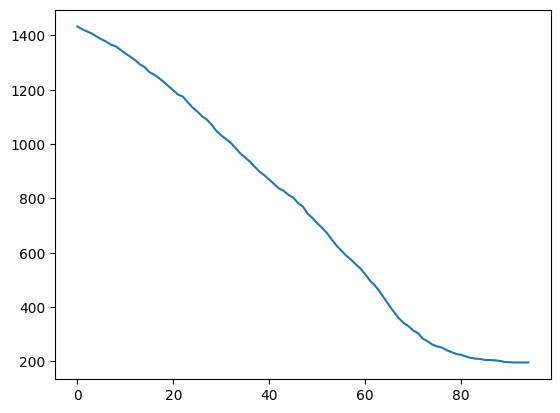

In [46]:
plt.plot(np.arange(95),len_list) # 포함되는 time_index의 갯수

<AxesSubplot: >

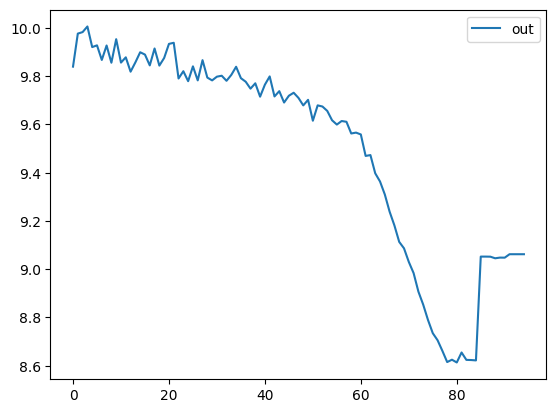

In [37]:
out_df.plot()

## Result
* 

In [38]:
len(index_list[-1])

196

In [39]:
len(index_list[-2])

196

In [40]:
len(index_list[-3])

196

In [41]:
len(index_list[-4])

196

In [42]:
len(index_list[-5])

197

In [45]:
len(index_list[-15])

224